# **Generating Deeptrack microscopy for classification and detection using a DINO framework**

Matilda Hellström. November 2025.

This notebook contains and descbribes the approach I have used for training a light weight version of DINO on generated microscopy data.

In [1]:
!pip install deeptrack
!pip install torchsummary

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 195.6/195.6 kB 4.9 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 306.8/306.8 kB 11.1 MB/s eta 0:00:00
  Created wheel for lazy_import: filename=lazy_import-0.2.2-py2.py3-none-any.whl size=16496 sha256=d737005b1dd3c907e03bfaafd7835a615fdd01719b293080798032cbb571e9d7
  Stored in directory: /root/.cache/pip/wheels/a4/71/2e/08ec0c8372739b0e20a7e48474312372031c5050d8c791c75f
Successfully built lazy_import


In [2]:
import deeptrack as dt
import math
import random
import time
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as T
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from types import MethodType
from scipy import ndimage as ndi
from random import randint
from scipy.ndimage import binary_propagation, maximum_filter, label, generate_binary_structure
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from sklearn.metrics.pairwise import cosine_distances
from sklearn.metrics import roc_curve, auc, accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from torchvision.transforms import InterpolationMode as IM
from torchsummary import summary
from torch.utils.data import ConcatDataset, DataLoader, Dataset, random_split
from collections import Counter, OrderedDict

/usr/local/lib/python3.11/dist-packages/deeptrack/__init__.py:14: UserWarning: TensorFlow is detected in your environment. DeepTrack2 version 2.0++ no longer supports TensorFlow. If you need TensorFlow support, please install the legacy version 1.7 of DeepTrack2:

    pip install deeptrack==1.7

For more details, refer to the DeepTrack documentation.
  warnings.warn(


# **Setup for generating synthetic data using Brightfield microscopy, the particle generators and the rendering pipeline**

make_image_feature defines the pipeline from the microscopy, addition of noise and the normalization. The labels are stored as "particle_type" (used for the labelled dataset, skipped for the unlabelled one).

In [3]:
noise = dt.Gaussian(sigma=0.05)
image_size = 64
brightfield_microscope = [dt.Brightfield(wavelength=500e-9,NA=1, resolution=1e-6, magnification=10, refractive_index_medium=1.33, illumination=0, upsample=1, output_region=(0, 0, image_size, image_size),)]

def make_image_feature(sample):
    incoh = brightfield_microscope[0](sample)
    return (incoh >> noise >> dt.NormalizeMinMax())

def sphere(no_part):
    sph = dt.Ellipsoid(
    position= lambda: 16+np.random.rand(2)*32,
    position_unit="pixel",
    radius= lambda:(30e-8, 30e-8, 30e-8),
    rotation=lambda: np.pi*np.random.rand(),
    particle_type = 0,)
    return (sph^no_part)

def ellipsoid(no_part):
    ell = dt.Ellipsoid(position= lambda: 16+np.random.rand(2)*32,
    position_unit="pixel",
    radius= lambda:(60e-8, 10e-8, 10e-8),
    rotation=lambda: np.pi*np.random.rand(),
    particle_type = 1,)
    return (ell^no_part)

# **Example images**

Displaying images containing a few particles and a combination of the two types.

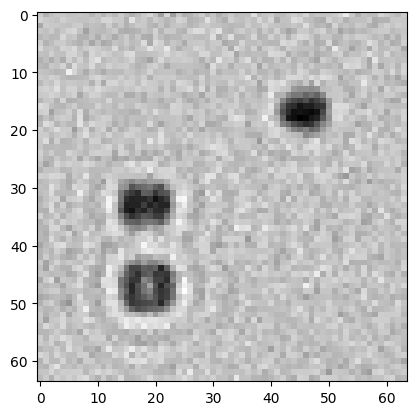

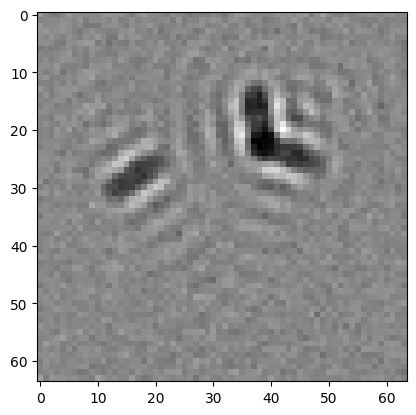

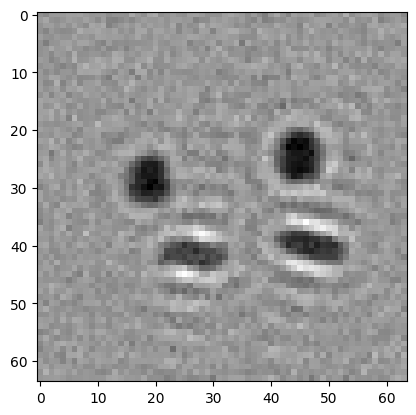

In [4]:
image_spheres  = make_image_feature(sphere((3)))
image_ellipsoids = make_image_feature(ellipsoid((3)))
image_both = make_image_feature(sphere((2)) & ellipsoid((2)))

image_spheres.store_properties()
for _ in range(1):
    image_spheres.update()
    image_spheres.plot(cmap="gray")
    plt.show()

image_ellipsoids.store_properties()
for _ in range(1):
    image_ellipsoids.update()
    image_ellipsoids.plot(cmap="gray")
    plt.show()

image_both.store_properties()
for _ in range(1):
    image_both.update()
    image_both.plot(cmap="gray")
    plt.show()

# **Parameter setup**

Defines crop sizes for global and local crops, the number of local crops, unlabelled and labelled images, batch sizes, number of epochs, learning rates and the EMA factor.

In [5]:
p_size_global = 32
p_size_local = 16

n_local = 4
n_unlab = 400
n_lab = 400

b_unlab = 32
b_train = 16
b_val = 16

ep_dino = 50
ep_probe = 8

lr_dino = 7e-4
wd_dino = 1e-4
lr_probe = 1e-3
wd_probe = 1e-4

ema_base= 0.996

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Device:", device)

Device: cuda


# **Data augmentation set up**
Defining the way in which we augment the images for the DINO training. The global crops will capture almost the whole image, whereas the local crop contain finer details. Padding was needed to avoid black edges after applying center_particle.

In [6]:
def make_global_aug(ps):
    """The global views, large crops"""
    return T.Compose([
        T.ConvertImageDtype(torch.float32),
        T.Pad(int(0.5*ps), padding_mode="edge"),
        T.RandomRotation(20, interpolation=IM.BILINEAR, expand=False),
        T.CenterCrop(ps),
        T.RandomResizedCrop(ps, scale=(0.9, 1.0)),
        T.GaussianBlur(3, sigma=(0.05, 0.1)),
        T.RandomHorizontalFlip(0.5),
        T.RandomVerticalFlip(0.5),])

def make_local_aug(ps):
    """The local views, more zoomed in"""
    return T.Compose([
        T.ConvertImageDtype(torch.float32),
        T.Pad(int(0.5*ps), padding_mode="edge"),
        T.RandomRotation(180, interpolation=IM.BILINEAR, expand=False),
        T.GaussianBlur(3, sigma=(0.05,0.1)),
        T.CenterCrop(ps),
        T.RandomHorizontalFlip(0.5),
        T.RandomResizedCrop(ps, scale=(0.4,0.6)),
        T.RandomVerticalFlip(0.5),])
    
def apply_aug_per_sample(aug, x):
    return torch.stack([aug(img) for img in x])

class MultiCrop:
    """Applies the global and local crops as seen above for a batch"""
    def __init__(self, ps_g, ps_l, n_local):
        self.g_aug = make_global_aug(ps_g)
        self.l_aug = make_local_aug(ps_l)
        self.n_local = n_local
        
    def __call__(self, x):
        g1 = apply_aug_per_sample(self.g_aug, x)
        g2 = apply_aug_per_sample(self.g_aug, x)
        local_crops = [apply_aug_per_sample(self.l_aug, x) for _ in range(self.n_local)]
        return [g1,g2] + local_crops

def center_particle(gen_img, patch_size):
    """Used to center a particle, redundant at the moment, but will be useful when 
    the particles are spawned at a random spot in the image"""
    img = np.asarray(gen_img)[..., 0].astype(np.float32)
    H,W = img.shape
    r = patch_size//2
    pad = np.pad(img,((r,r),(r,r)), mode='edge')
    crops, labels, positions = [],[],[]
    for prop in getattr(gen_img, "properties", []):
        if "position" not in prop: 
            continue
        # Using the particle position to center the crop around it
        # Need to rebuild this as position information won't be available later on
        y, x = prop["position"]
        cy = int(np.clip(y, 0, H-1))+r
        cx = int(np.clip(x, 0, W-1))+r
        crop = pad[cy-r:cy+r, cx-r:cx+r]
        crops.append(crop[None, ...])
        positions.append((y,x))
        labels.append(int(prop.get("particle_type",-1)))
    return crops, labels, positions

class UnlabeledPatchDataset(Dataset):
    """Creates the unlabelled images that will be used for the DINO training"""
    def __init__(self, image_feature, n_images, patch_size):
        self.crops = []
        for _ in range(n_images):
            img_DT = image_feature.update().resolve(skip_augmentations=False)
            cs, _, _ = center_particle(img_DT, patch_size)
            self.crops.extend(cs)
        rng = np.random.default_rng(0)
        rng.shuffle(self.crops)
    def __len__(self): 
        return len(self.crops)
    def __getitem__(self, i): 
        return torch.from_numpy(self.crops[i]).float()

class LabeledPatchDataset(Dataset):
    """Creates the labelled data that will be used for the linear probe training 
    and the evaulation."""
    def __init__(self, image_feature, n_images, patch_size, include_types=(0,1,2)):
        self.samples = []
        for _ in range(n_images):
            img_DT = image_feature.update().resolve(skip_augmentations=False)
            cs, ys, positions = center_particle(img_DT, patch_size)
            for c, y in zip(cs, ys):
                if y in include_types:
                    self.samples.append((c, y))
        rng = np.random.default_rng(1)
        rng.shuffle(self.samples)
    def __len__(self): 
        return len(self.samples)
    def __getitem__(self, i):
        c, y = self.samples[i]
        return torch.from_numpy(c).float(), torch.tensor(y, dtype=torch.long)

# **Creating the datasets**
Both the unlabelled - for unsupervised learning - and labelled - for evaluation.

In [7]:
multi_crop = MultiCrop(ps_g=p_size_global, ps_l=p_size_local, n_local=n_local)

print("Creating the unlabelled datasets.")
unlab_s = UnlabeledPatchDataset(image_spheres, n_images=n_unlab//2, patch_size=p_size_global)
unlab_e = UnlabeledPatchDataset(image_ellipsoids, n_images=n_unlab-n_unlab//2, patch_size=p_size_global)
unlab_ds = ConcatDataset([unlab_s, unlab_e])
unlab_loader = DataLoader(unlab_ds, batch_size=b_unlab, shuffle=True, drop_last=True)

print("Creating the labelled datasets.")
lab_s = LabeledPatchDataset(image_spheres,  n_images=n_lab//2, patch_size=p_size_global)
lab_e = LabeledPatchDataset(image_ellipsoids, n_images=n_lab - n_lab//2, patch_size=p_size_global)
lab_ds = ConcatDataset([lab_s, lab_e])

print("Creating the validation and training data.")
n_val = int(len(lab_ds)*0.4)
n_train = len(lab_ds) - n_val
train_ds, val_ds = random_split(lab_ds,[n_train, n_val])

train_loader = DataLoader(train_ds, batch_size=b_train, shuffle=True, drop_last=False)
val_loader = DataLoader(val_ds, batch_size=b_val,shuffle=False, drop_last=False)
print("Unlab:", len(unlab_ds), "Train:", len(train_ds), "Val:", len(val_ds))

Creating the unlabelled datasets.
Creating the labelled datasets.
Creating the validation and training data.
Unlab: 1200 Train: 720 Val: 480


# **Examples of the unaugmented unlabelled images**

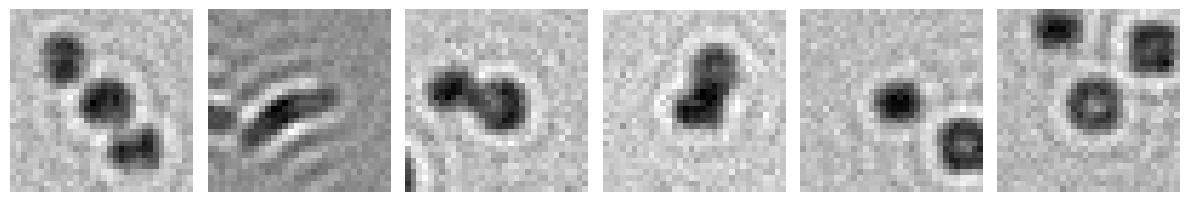

In [8]:
xb = next(iter(unlab_loader))
n_show = 6
fig, axes = plt.subplots(1,6,figsize=(12,6))
axes = axes.ravel()

for i in range(n_show):
    img = xb[i,0].cpu().numpy()
    axes[i].imshow(img, cmap="gray")
    axes[i].axis("off")
for j in range(n_show, len(axes)):
    axes[j].axis("off")
plt.tight_layout()
plt.show()

# **Composition check**

Making sure that the datasets contain about the same amount of spheres and ellipsoids.


In [9]:
print("Training split 0/1:", Counter(int(train_ds[i][1]) for i in range(len(train_ds))))
print("Validation split 0/1:", Counter(int(val_ds[i][1]) for i in range(len(val_ds))))

Training split 0/1: Counter({0: 368, 1: 352})
Validation split 0/1: Counter({1: 248, 0: 232})


# The CNN-encoder setup

The original DINO model uses ViTs as encoders, but for such a simple task as this one, ViTs are too large and data demanding. Thus, a CNN works well as the backbone of this DINO version - at least when using the generated dataset from above.

The encoder takes an image and compresses the features into a 256-dim vector embedding using three conv blocks, global pooling and a projection layer (mapping to 256 dim). Using BatchNorm1d for normalization before passing the output to the DINO-head.

In [10]:
class CNNEncoder(nn.Module):
    """Takes an image, extracts details and compresses it into a vector embedding
    with out_dim 256 that is passed to the DINOHead."""
    def __init__(self, in_chans=1, out_dim=256):
        super().__init__()
        self.backbone = nn.Sequential(
            nn.Conv2d(in_chans,16,3,padding=1), nn.GELU(),
            nn.Conv2d(16,16,3,padding=1),nn.GELU(),
            nn.MaxPool2d(2),
            nn.Conv2d(16,32,3,padding=1), nn.GELU(),
            nn.Conv2d(32,32,3,padding=1), nn.GELU(),
            nn.MaxPool2d(2),
            nn.Conv2d(32,64,3,padding=1), nn.GELU(),
            nn.Conv2d(64,64,3,padding=1), nn.GELU(),
            nn.AdaptiveAvgPool2d(1),)
        self.proj = nn.Conv2d(64, out_dim, 1,bias=False)
        self.bn = nn.BatchNorm1d(out_dim, affine=False)
        self.out_dim = out_dim

    def forward(self, x):
        h = self.backbone(x)
        z = self.proj(h).flatten(1)
        z = self.bn(z)
        return z

# **The DINO-head**
A small mlp that recieves the encoder 256-dim output feature vectors. The hidden layers serve to capture non-linear patters. Note the weight normlization applied in the last layer.

In [11]:
class DINOHead(nn.Module):
    """Takes the output from the encoder and uses a three layer MLP to 
    learn even finer details. Outputs a 256 dim vector embedding"""
    def __init__(self, in_dim, out_dim, hidden=32, bn_last=True):
        super().__init__()
        self.mlp = nn.Sequential(nn.Linear(in_dim, hidden), nn.GELU(),
            nn.Linear(hidden, hidden),nn.GELU(), 
            nn.Linear(hidden, out_dim))
        if bn_last:
            self.mlp[-1] = nn.utils.parametrizations.weight_norm(self.mlp[-1])
        self.out_dim = out_dim
    def forward(self, x): 
        return self.mlp(x)

# **The DINO-loss**

Utilizes the DINO framework for aligning the student and teacher network predicions. The probabilities are modified using temperatures (a schedule for the teacher to stabilise even further) - that serve to stabilise and sharpen the output distributions before applying softmax to obtain the probabilities. The views are then compared and the loss computed. Centering of the teacher output is used in the same fashion as in the original paper.

In [12]:
class DINOLoss(nn.Module):
    """Computes and returns the cross entropy loss between the teacher and student predictions"""
    def __init__(self, out_dim, warmup_teacher_temp=0.07, teacher_temp=0.1,
                 warmup_epochs=3, total_epochs=ep_dino, student_temp=0.2, center_momentum=0.9):
        super().__init__()
        self.student_temp = student_temp
        self.center_m = center_momentum
        self.register_buffer("center", torch.zeros(1, out_dim))
        self.temp_sched = torch.cat([torch.linspace(warmup_teacher_temp, teacher_temp, warmup_epochs), torch.ones(total_epochs - warmup_epochs) *teacher_temp])
        
    def forward(self, student_out_list, teacher_out_list, epoch):
        student_out_list = [s/self.student_temp for s in student_out_list]
        temp = self.temp_sched[min(epoch, len(self.temp_sched)-1)].item()
        with torch.no_grad():
            teacher_probs = [F.softmax((t-self.center)/temp, dim=-1) for t in teacher_out_list]
        total,n = 0,0

        for iq, q in enumerate(teacher_probs):
            for v, p in enumerate(student_out_list):
                if v == iq:
                    continue
                total += torch.sum(-q *F.log_softmax(p, dim=-1), dim=-1).mean()
                n += 1
        total = total/max(1,n)
        with torch.no_grad():
            batch_center = torch.cat(teacher_probs, dim=0).mean(0, keepdim=True)
            self.center = self.center * self.center_m + batch_center *(1 - self.center_m) 
        return total

def cosine_momentum(base=ema_base, step=0, total=1000):
    """The momentum coefficitent used for the teacher"""
    return 1 - (1- base)*(0.5 * (1 + math.cos(math.pi * step/total)))

In [13]:
enc_s = CNNEncoder().to(device)
enc_t = CNNEncoder().to(device)
enc_t.load_state_dict(enc_s.state_dict())
for p in enc_t.parameters():
    p.requires_grad = False
enc_t.eval()

head_s = DINOHead(in_dim=enc_s.out_dim, out_dim=256).to(device)
head_t = DINOHead(in_dim=enc_s.out_dim, out_dim=256).to(device)
head_t.load_state_dict(head_s.state_dict())
for p in head_t.parameters():
    p.requires_grad = False
head_t.eval()

dino_l = DINOLoss(out_dim=256, total_epochs=ep_dino).to(device)
opt = torch.optim.AdamW(list(enc_s.parameters()) + list(head_s.parameters()), lr=lr_dino, weight_decay=wd_dino)

# **Model summaries**

In [14]:
model_cnn = CNNEncoder().to(device)
summary(model_cnn,input_size=(1, 32, 32),device=str(device))

model_dino = DINOHead(model_cnn.out_dim, model_cnn.out_dim).to(device)
summary(model_dino,input_size=(model_cnn.out_dim,),device=str(device))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 32, 32]             160
              GELU-2           [-1, 16, 32, 32]               0
            Conv2d-3           [-1, 16, 32, 32]           2,320
              GELU-4           [-1, 16, 32, 32]               0
         MaxPool2d-5           [-1, 16, 16, 16]               0
            Conv2d-6           [-1, 32, 16, 16]           4,640
              GELU-7           [-1, 32, 16, 16]               0
            Conv2d-8           [-1, 32, 16, 16]           9,248
              GELU-9           [-1, 32, 16, 16]               0
        MaxPool2d-10             [-1, 32, 8, 8]               0
           Conv2d-11             [-1, 64, 8, 8]          18,496
             GELU-12             [-1, 64, 8, 8]               0
           Conv2d-13             [-1, 64, 8, 8]          36,928
             GELU-14             [-1, 6

# **DINO training**
Here, we train the student and teacher networks using the DINO framework as described above.

In [15]:
iters_per_epoch = len(unlab_loader)
global_step = 0

dino_train_loss = []
probe_train_loss = []
probe_val_loss = []
probe_val_acc = []

enc_t.eval()
head_t.eval()

for ep in range(ep_dino):
    enc_s.train()
    head_s.train()
    t0 = time.time()
    running = 0.0

    for x in unlab_loader:
        views = multi_crop(x)
        views = [v.to(device, non_blocking=True) for v in views]

        # Only the global crops to the teacher
        with torch.no_grad():
            t_out = [head_t(enc_t(views[i])) for i in (0,1)]

        # Global and local crops to the student
        s_out = [head_s(enc_s(v)) for v in views]

        loss = dino_l(s_out, t_out, epoch=ep)
        opt.zero_grad()
        loss.backward()
        opt.step()

        # EMA for the teacher update
        m = cosine_momentum(base=ema_base, step=global_step, total=ep_dino * iters_per_epoch)
        global_step += 1
        
        with torch.no_grad():
            for ps, pt in zip(enc_s.parameters(), enc_t.parameters()):
                pt.data.mul_(m).add_((1-m) * ps.data)
            for ps, pt in zip(head_s.parameters(), head_t.parameters()):
                pt.data.mul_(m).add_((1-m) * ps.data)
        running += loss.item()*x.size(0)
    denom = (len(unlab_loader.dataset)-len(unlab_loader.dataset) % unlab_loader.batch_size)
    loss_ep = running / max(1, denom)
    dino_train_loss.append(loss_ep)
    print(f"Epoch {ep+1}/{ep_dino}, loss={loss_ep:.4f}, time={time.time()-t0:.1f}s")

Epoch 1/50, loss=5.0248, time=9.1s
Epoch 2/50, loss=5.0083, time=8.6s
Epoch 3/50, loss=5.0513, time=8.7s
Epoch 4/50, loss=4.9885, time=8.4s
Epoch 5/50, loss=4.9287, time=8.6s
Epoch 6/50, loss=4.8713, time=8.6s
Epoch 7/50, loss=4.8163, time=8.8s
Epoch 8/50, loss=4.7639, time=8.5s
Epoch 9/50, loss=4.7142, time=8.8s
Epoch 10/50, loss=4.6673, time=8.6s
Epoch 11/50, loss=4.6231, time=8.6s
Epoch 12/50, loss=4.5814, time=8.5s
Epoch 13/50, loss=4.5421, time=8.6s
Epoch 14/50, loss=4.5052, time=8.4s
Epoch 15/50, loss=4.4706, time=8.4s
Epoch 16/50, loss=4.4374, time=8.5s
Epoch 17/50, loss=4.4058, time=8.3s
Epoch 18/50, loss=4.3764, time=8.3s
Epoch 19/50, loss=4.3488, time=8.5s
Epoch 20/50, loss=4.3229, time=8.4s
Epoch 21/50, loss=4.2983, time=8.4s
Epoch 22/50, loss=4.2768, time=8.2s
Epoch 23/50, loss=4.2569, time=8.2s
Epoch 24/50, loss=4.2396, time=8.4s
Epoch 25/50, loss=4.2239, time=8.2s
Epoch 26/50, loss=4.2103, time=8.4s
Epoch 27/50, loss=4.1978, time=8.4s
Epoch 28/50, loss=4.1867, time=8.4s
E

# Linear classifier 
Using a linear classsifier to test how well the learned representations can be used for separating the spheres and elliposids.

In [16]:
def eval_loss(loader, probe):
    """Returns the mean ce-loss for the classifier over the entire validation set"""
    enc_s.eval()
    probe.eval()
    total_loss = 0.0
    total_samples = 0
    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            z = enc_s(x)
            logits = probe(z)
            loss = ce(logits, y)
            bs = y.size(0)
            total_loss += loss.item()*bs
            total_samples += bs
    return total_loss/max(1,total_samples)

def eval_acc(loader, probe):
    """Computes and returns the evaluation accuracy given a loader"""
    enc_s.eval()
    probe.eval()
    corr = 0
    tot = 0
    with torch.no_grad():
        for x,y in loader:
            x,y = x.to(device), y.to(device)
            z = enc_s(x)
            logits = probe(z)
            pred = logits.argmax(1)
            corr += (pred==y).sum().item()
            tot += y.numel()
    return corr/max(1,tot)

for p in enc_s.parameters():
    p.requires_grad = False

enc_s.eval()
linear_dino = nn.Linear(enc_s.out_dim, 2).to(device)
opt_lin = torch.optim.Adam(linear_dino.parameters(), lr=lr_probe, weight_decay=wd_probe)
ce = nn.CrossEntropyLoss()

for ep in range(1, ep_probe +1):
    enc_s.eval()
    linear_dino.train()
    run = 0.0
    for x, y in train_loader:
        x, y = x.to(device), y.to(device)
        with torch.no_grad():
            z = enc_s(x)
        logits = linear_dino(z)
        loss = ce(logits, y)
        opt_lin.zero_grad()
        loss.backward()
        opt_lin.step()
        run += loss.item() * x.size(0)
    tr_loss = run / len(train_loader.dataset)
    val_acc = eval_acc(val_loader,linear_dino)
    val_loss = eval_loss(val_loader,linear_dino)
    probe_train_loss.append(tr_loss)
    probe_val_loss.append(val_loss)
    probe_val_acc.append(val_acc)
    
    print(f"Epoch {ep}/{ep_probe}, loss={tr_loss:.4f}, val_acc={val_acc:.4f}")

Epoch 1/8, loss=0.1369, val_acc=0.9875
Epoch 2/8, loss=0.0399, val_acc=0.9875
Epoch 3/8, loss=0.0382, val_acc=0.9896
Epoch 4/8, loss=0.0375, val_acc=0.9875
Epoch 5/8, loss=0.0372, val_acc=0.9875
Epoch 6/8, loss=0.0371, val_acc=0.9896
Epoch 7/8, loss=0.0369, val_acc=0.9875
Epoch 8/8, loss=0.0367, val_acc=0.9875


# **Example images, true labels and predcitions**

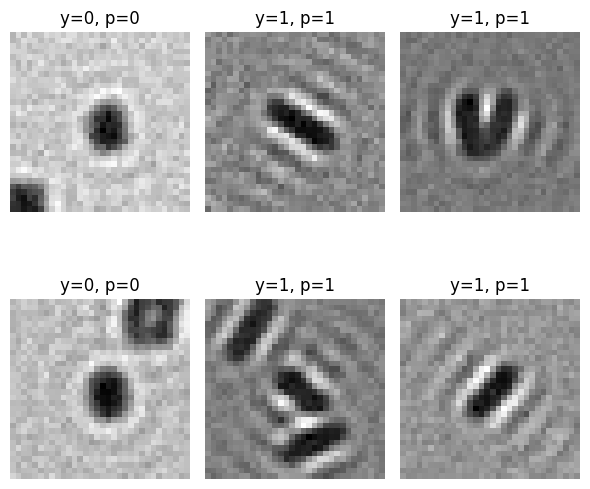

In [17]:
xb, yb = next(iter(val_loader))
with torch.no_grad():
    zb = enc_s(xb.to(device))
    pr = F.softmax(linear_dino(zb), dim=1).cpu().numpy()
    
pred = pr.argmax(1)
n_show = 6
fig, axes = plt.subplots(2, 3, figsize=(6,6))
axes = axes.ravel()

for i in range(n_show):
    axes[i].imshow(xb[i,0], cmap='gray')
    axes[i].set_title(f"y={yb[i].item()}, p={pred[i]}")
    axes[i].axis('off')
plt.tight_layout()
plt.show()

# **Global and local crops**

Here follows some examples of the global and local viees which we feed the student and teacher networks.

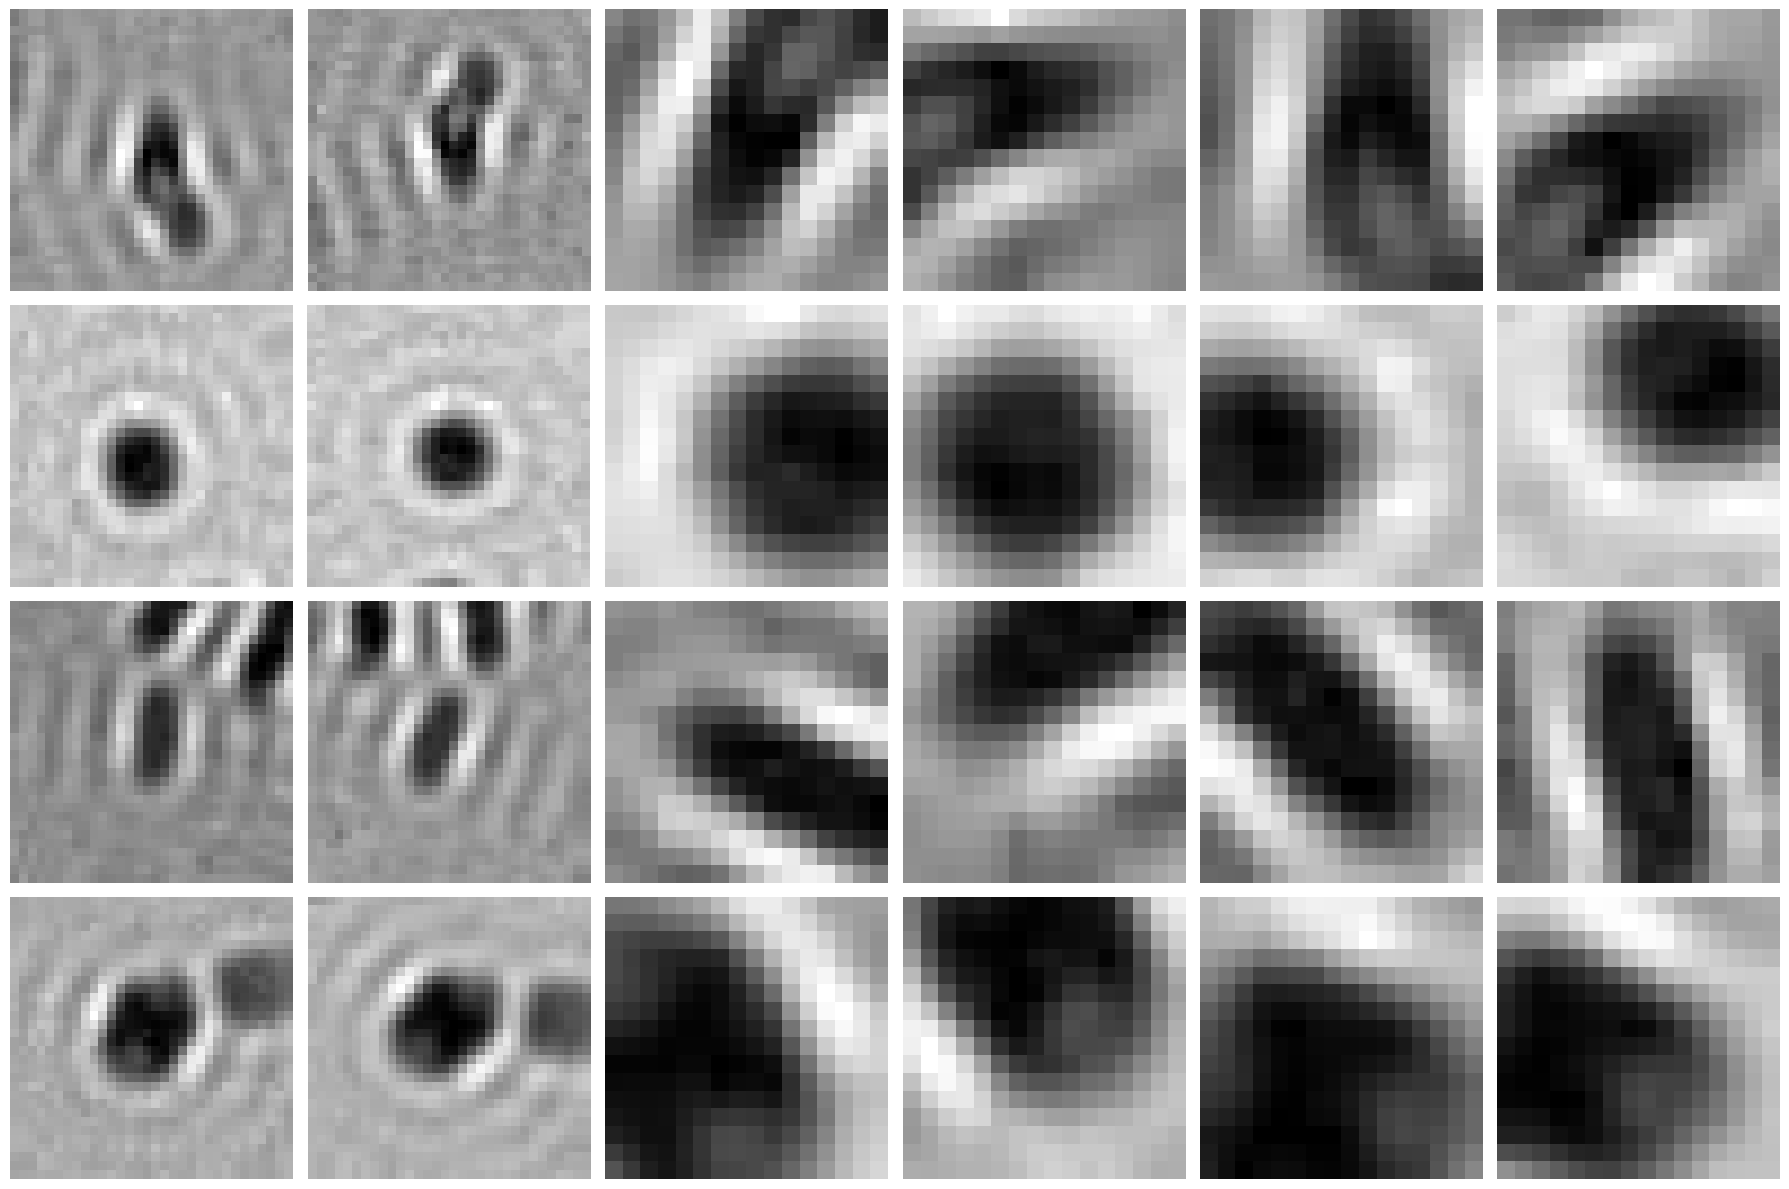

In [18]:
xb = next(iter(unlab_loader))
views = multi_crop(xb)
n_views = len(views)
n_examples = 4
fig, axes = plt.subplots(n_examples, n_views,figsize=(3*n_views, 3*n_examples))

for r in range(n_examples):
    for c, v in enumerate(views):
        img = v[r,0].detach().cpu()
        axes[r,c].imshow(img, cmap="gray")
        axes[r,c].axis("off")
plt.tight_layout()
plt.show()

# **Batch composition**

Making sure that we have about the same amount of spheres and ellipsoids.

In [19]:
for i, (_, y) in zip(range(3), train_loader):
    print(f"Composition of batch number {i}:", Counter(y.tolist()))

Composition of batch number 0: Counter({1: 11, 0: 5})
Composition of batch number 1: Counter({0: 9, 1: 7})
Composition of batch number 2: Counter({1: 10, 0: 6})


# **Evaluation on the validation set**

And displaying the classes and probabilites.

In [20]:
linear_dino.eval()
all_probs = []
all_labels = []

with torch.no_grad():
    for x, y in val_loader:
        x = x.to(device)
        z = enc_s(x)
        logits = linear_dino(z)
        probs = torch.softmax(logits, dim=1)
        all_probs.append(probs.cpu())
        all_labels.append(y.cpu())

all_probs = torch.cat(all_probs).numpy()
all_labels = torch.cat(all_labels).numpy()

print("\n")
for i in range(10):
    print(f"True class: {all_labels[i]}")
    print(f"Probs for 0 and 1: {all_probs[i]}")
    print(f"Predicted class: {all_probs[i].argmax()}")
    print("-" * 40)



True class: 0
Probs for 0 and 1: [9.99999881e-01 1.03519504e-07]
Predicted class: 0
----------------------------------------
True class: 1
Probs for 0 and 1: [0.10094137 0.89905864]
Predicted class: 1
----------------------------------------
True class: 1
Probs for 0 and 1: [1.8384047e-07 9.9999976e-01]
Predicted class: 1
----------------------------------------
True class: 0
Probs for 0 and 1: [9.999621e-01 3.790150e-05]
Predicted class: 0
----------------------------------------
True class: 1
Probs for 0 and 1: [5.2766313e-07 9.9999952e-01]
Predicted class: 1
----------------------------------------
True class: 1
Probs for 0 and 1: [5.2033378e-05 9.9994791e-01]
Predicted class: 1
----------------------------------------
True class: 1
Probs for 0 and 1: [3.2184303e-07 9.9999964e-01]
Predicted class: 1
----------------------------------------
True class: 1
Probs for 0 and 1: [0.01701607 0.98298395]
Predicted class: 1
----------------------------------------
True class: 0
Probs for 0 

# **Using PCA to visualise the learned feature spaces**
Projecting the high-dim feature spaces to 2D to see if clusters are formed incidating that the model is learning something meaningful.

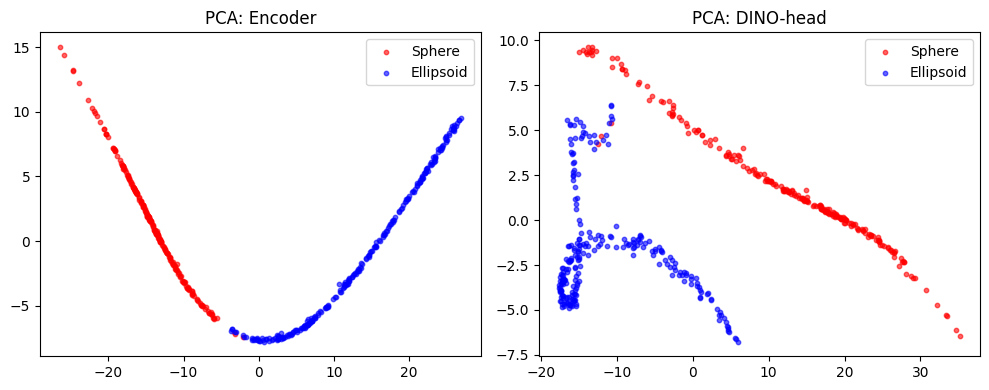

In [22]:
def pca2(X):
    Xs = StandardScaler().fit_transform(X)
    return PCA(n_components=2).fit_transform(Xs) 
    
enc_s.eval()
fe_enc, fe_head, ys = [], [], []

with torch.no_grad():
    for xb, yb in val_loader:
        xb = xb.to(device)
        z  = enc_s(xb)
        h  = head_s(z)
        fe_enc.append(z.cpu())
        fe_head.append(h.cpu())
        ys.append(yb.cpu())

X_enc  = torch.cat(fe_enc).numpy()
X_head = torch.cat(fe_head).numpy()
y = torch.cat(ys).numpy()
Z_enc  = pca2(X_enc)
Z_head = pca2(X_head)
mask0 = (y == 0)
mask1 = (y == 1)

fig, axes = plt.subplots(1, 2, figsize=(10,4))
ax = axes[0]
ax.scatter(Z_enc[mask0, 0], Z_enc[mask0, 1], c="red", label="Sphere")
ax.scatter(Z_enc[mask1, 0], Z_enc[mask1, 1], c="blue", label="Ellipsoid")
ax.set_title("PCA: Encoder")
ax.legend()
ax = axes[1]
ax.scatter(Z_head[mask0, 0], Z_head[mask0, 1], c="red", label="Sphere")
ax.scatter(Z_head[mask1, 0], Z_head[mask1, 1], c="blue", label="Ellipsoid")
ax.set_title("PCA: DINO-head")
ax.legend()
plt.tight_layout()
plt.show()

# **RBG PCA**
Using PC1, PC2 and PC3 for smaller patches of an image to create a RGB image by combining the PCA components. Hence, we can see how different regions are encoded and what the different PCA components actually "capture".

Patch PCA EVR: [0.84941745 0.13263151 0.01058678] and summed value: 0.9926358


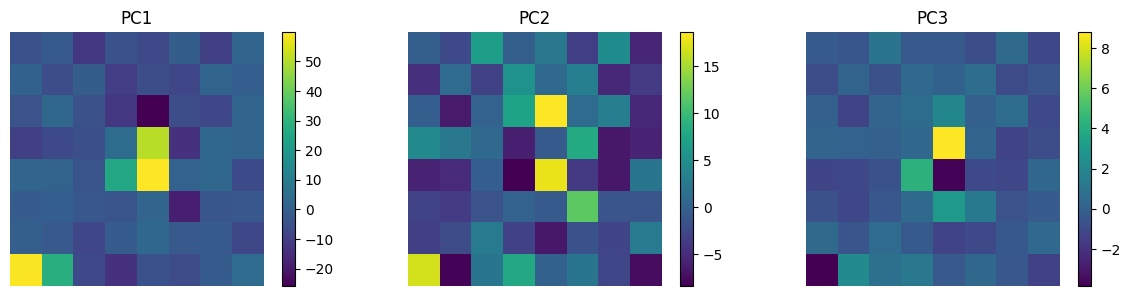

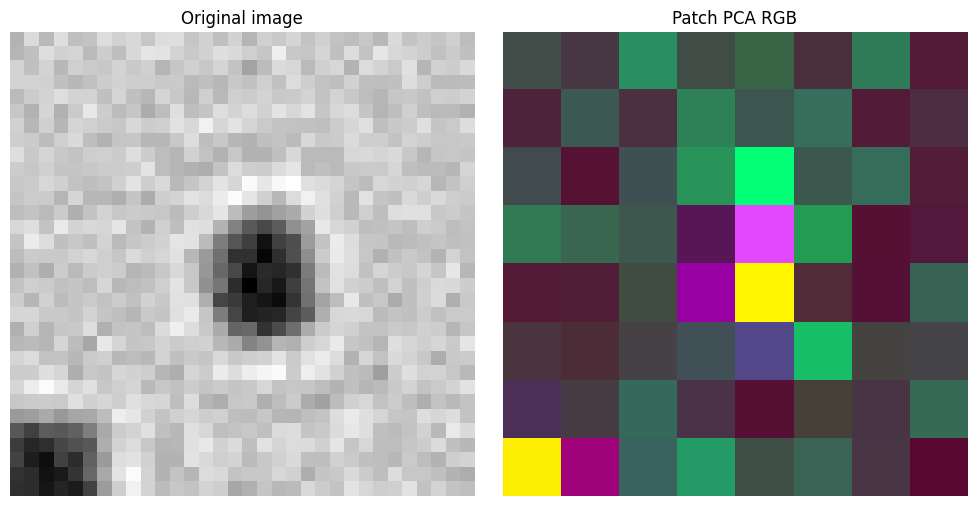

In [39]:
enc_s.eval()
with torch.no_grad():
    xb_val , _ = next(iter(val_loader))
    x_img = xb_val[0:1].to(device)

patch = 4
x = x_img
ny, nx = 32//patch, 32//patch
tiles = []

for r in range(ny):
    for c in range(nx):
        y0, y1 = r*patch, (r+1)*patch
        x0, x1 = c*patch, (c+1)*patch
        t = x[:, :, y0:y1, x0:x1]
        t = F.interpolate(t, (32,32), mode='bilinear')
        tiles.append(t)

X = torch.cat(tiles,dim=0)
with torch.no_grad():
    Z = enc_s(X).detach().cpu().numpy()

sc = StandardScaler().fit(Z)
Zs = sc.transform(Z)
pca = PCA(n_components=3).fit(Zs)
Z3 = pca.transform(Zs)
Z_grid = Z3.reshape(ny, nx, 3)

print("Patch PCA EVR:", pca.explained_variance_ratio_, "and summed value:", pca.explained_variance_ratio_.sum())

fig, axes = plt.subplots(1, 3, figsize=(12,3))
for i, ax in enumerate(axes):
    im = ax.imshow(Z_grid[..., i])
    ax.set_title(f"PC{i+1}")
    ax.axis('off')
    plt.colorbar(im, ax=ax)
plt.tight_layout()
plt.show()

min_val = Z_grid.min(axis=(0,1), keepdims=True)
max_val = Z_grid.max(axis=(0,1), keepdims=True)
rgb = (Z_grid- min_val)/(max_val-min_val)
pca_rgb = torch.from_numpy(rgb).permute(2,0,1).unsqueeze(0)
pca_rgb = F.interpolate(pca_rgb, size=(32,32))[0].permute(1,2,0).numpy()

img_np = x_img[0,0].cpu().numpy()
fig, ax = plt.subplots(1, 2, figsize=(10,5))
ax[0].imshow(img_np, cmap="gray")
ax[0].set_title("Original image")
ax[0].axis("off")
ax[1].imshow(pca_rgb)
ax[1].set_title("Patch PCA RGB")
ax[1].axis("off")
plt.tight_layout()
plt.show()

# **Showing the nearest neighbours from the feature space**

Just ensuring that the nearest neighbours for an embedding looks similiar. Will be very useful when the data is more complex! Also showing the kNN accuracy score.

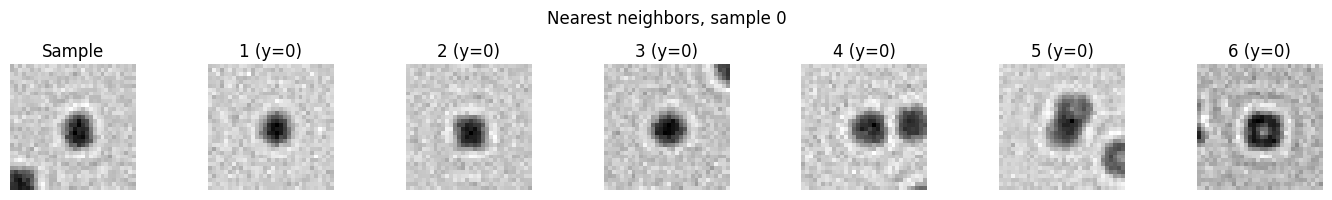

In [40]:
def show_neighbors(sample_idx, a, embeddings, labels,images):
    """Function for visualising the nearest neighbours in feature space given an embedding."""
    emb = embeddings[sample_idx:sample_idx+1]
    dist = cosine_distances(emb, embeddings)[0]
    nn = np.argsort(dist)[:a+1]
    cols = a+1
    plt.figure(figsize=(2*cols, 2))
    for j, idx in enumerate(nn):
        plt.subplot(1, cols, j+1)
        plt.imshow(images[idx,0],cmap="gray")
        title = "Sample" if idx==sample_idx else f"{j} (y={labels[idx]})"
        plt.title(title)
        plt.axis("off")
    plt.suptitle(f"Nearest neighbors, sample {sample_idx}")
    plt.tight_layout()
    plt.show()

images, embeddings, labels = [], [], []
with torch.no_grad():
    for xb, yb in val_loader:
        zb = enc_s(xb.to(device)).cpu().numpy()
        embeddings.append(zb) 
        labels.append(yb.numpy())
        images.append(xb.numpy()) 
embeddings = np.concatenate(embeddings)
labels = np.concatenate(labels)
images = np.concatenate(images)

show_neighbors(0,6, embeddings, labels, images)

In [41]:
def load_emb(loader, encoder, device):
    """Passes the images trough the encoder and returns the embeddings."""
    z1, y1 = [], []
    with torch.no_grad():
        for xb, yb in loader:
            xb = xb.to(device)
            z = encoder(xb).cpu().numpy()
            z1.append(z)
            y1.append(yb.numpy())
    return np.concatenate(z1), np.concatenate(y1)

def knn_on_emb(X_train, y_train, X_test, y_test, k):
    """Using k-NN classification to analyse what the encoder has learned."""
    knn = KNeighborsClassifier(k, metric="cosine")
    knn.fit(X_train, y_train)
    preds = knn.predict(X_test)
    acc = accuracy_score(y_test,preds)
    print(f"kNN accuracy for k={k}: {acc:.3f}")
    
emb_train, lab_train = load_emb(train_loader,enc_s, device)
emb_val, lab_val = load_emb(val_loader, enc_s, device)
knn_on_emb(emb_train, lab_train, emb_val, lab_val, 5)

kNN accuracy for k=5: 0.990


# **t-SNE**

Trying out how scikit t-SNE works with the data as well. Will also be useful later on when dealing with more complex data.

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 480 samples in 0.000s...
[t-SNE] Computed neighbors for 480 samples in 0.011s...
[t-SNE] Computed conditional probabilities for sample 480 / 480
[t-SNE] Mean sigma: 1.689160
[t-SNE] Computed conditional probabilities in 0.011s
[t-SNE] Iteration 50: error = 48.8480873, gradient norm = 0.0579549 (50 iterations in 0.085s)
[t-SNE] Iteration 100: error = 45.2687035, gradient norm = 0.0194669 (50 iterations in 0.064s)
[t-SNE] Iteration 150: error = 44.5465851, gradient norm = 0.0066237 (50 iterations in 0.063s)
[t-SNE] Iteration 200: error = 44.3069611, gradient norm = 0.0148812 (50 iterations in 0.063s)
[t-SNE] Iteration 250: error = 44.2036591, gradient norm = 0.0138893 (50 iterations in 0.065s)
[t-SNE] KL divergence after 250 iterations with early exaggeration: 44.203659
[t-SNE] Iteration 300: error = 0.2229699, gradient norm = 0.0086417 (50 iterations in 0.064s)
[t-SNE] Iteration 350: error = 0.1698073, gradient norm = 0.0056777 (

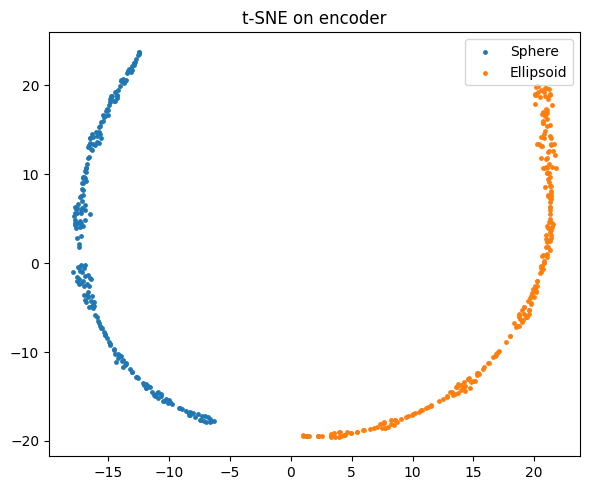

In [42]:
tsne = TSNE(n_components=2, perplexity=30, init="pca", learning_rate="auto", n_iter=1000, verbose=2)
Z_enc = tsne.fit_transform(X_enc)

plt.figure(figsize=(6,5))
plt.scatter(Z_enc[y==0,0], Z_enc[y==0,1], label="Sphere", s=6)
plt.scatter(Z_enc[y==1,0], Z_enc[y==1,1], label="Ellipsoid", s=6)
plt.title("t-SNE on encoder")
plt.legend()
plt.tight_layout()
plt.show()

# **Tile creator function**
create_tiles splits an image into tiles and returns both tiles and the tile coordinates so that we can use these for classifying the content of a large image.

In [27]:
def create_tiles(img, grid):
    """Splits an image into tiles and returns these and the corresponding coordinates."""
    H, W = img.shape
    R, C = grid
    h = H//R
    w = W//C
    tiles = []
    coords = []
    for r in range(R):
        for c in range(C):
            y0, y1 = r*h, (r+1)*h if r < R-1 else H 
            x0, x1 = c*w, (c+1)*w if c < C-1 else W
            tiles.append(img[y0:y1,x0:x1])
            coords.append((r, c, y0, y1, x0, x1))
    return tiles, coords

# **Function for classifing tiles using the trained networks**
We feed each tile to the DINO encoder and compute the probabilities for each tile containing a certain class and the most likely class.

In [28]:
def predict_on_tiles(tiles, device, encoder, head, resize_to):
    """ Using the frozen encoder + dino-head to get probabilites for a tile containing a particle plus the predictions."""
    with torch.no_grad():
        xs = []
        for t in tiles:
            t = t.astype(np.float32)
            tt = torch.from_numpy(t[None, None, ...])
            tt = F.interpolate(tt, size=(resize_to, resize_to), mode='bilinear')
            t = tt[0,0].numpy()
            xs.append(t[None, ...])
        x = torch.from_numpy(np.stack(xs, axis=0)).to(device)
        z = encoder(x)
        logits = head(z)
        probs = torch.softmax(logits, dim=1).cpu().numpy()
        preds = probs.argmax(1)
    return probs

# **Grad-CAM for each tile**
Gives an understanding of what regions that the model are actually focusing on to make the predictions. To do this, a forwardhook is attached to a layer (after testing, -3 seems to be the best one) so that the activations and gradients can be "grabbed" during the forward and backward passes. The activations and gradients are then when creating the grad-CAM overlays. 

In [29]:
def gradcam(tiles, device, encoder, head, cam_layer, resize_to):
    """Gives the gradCAM for each tile so that we can see what is actually focused on"""
    encoder.eval()
    head.eval()
    encoder.requires_grad_(True)
    head.requires_grad_(True)
    orig_sizes = []
    batched = []
    for t in tiles:
        t = t.astype(np.float32)
        orig_sizes.append(t.shape)
        tt = torch.from_numpy(t[None, None, ...])
        tt = F.interpolate(tt, size=(resize_to, resize_to), mode='bilinear', align_corners=False)
        batched.append(tt)
    x = torch.cat(batched, dim=0).to(device)
    
    acts = {}
    grads = {}

    def fwd_hook(module, inp, out):
        acts['feat'] = out
        def save_grad(g):
            grads['feat'] = g
        out.register_hook(save_grad)

    handle = cam_layer.register_forward_hook(fwd_hook)
    logits = head(encoder(x))
    target = logits.argmax(1)
    encoder.zero_grad(set_to_none=True)
    head.zero_grad(set_to_none=True)
    scores = logits[torch.arange(logits.size(0), device=logits.device), target]
    scores.sum().backward()

    with torch.no_grad():
        A = acts['feat']
        G = grads['feat']
        w = G.mean(dim=(2,3), keepdim=True)
        cam = torch.relu((w*A).sum(dim=1, keepdim=True))
        cams = []
        for i, (h, w_) in enumerate(orig_sizes):
            cam_i = cam[i:i+1]
            cam_i = F.interpolate(cam_i, size=(h, w_), mode='bilinear')[0,0]
            cmin, cmax = cam_i.min(), cam_i.max()
            cam_i = (cam_i-cmin)/(cmax-cmin + 1e-6)
            cams.append(cam_i.cpu().numpy())
    handle.remove()
    return cams

# **Applying the tile-creation, classfication and grad-CAM functions to a test image**
We now create the tiles, classify and create the grad-CAM overlays given an image. We ignore tiles with low variance as they are likely to not contain any particles.

In [30]:
def apply_on_test_image(img_DT,grid, device, encoder, head, resize_to, none_threshold, presence_quantile):
    arr = np.asarray(img_DT)[..., 0].astype(np.float32)
    tiles, coords = create_tiles(arr, grid=grid)
    scores = np.array([float(t.astype(np.float32).var()) for t in tiles])
    keep_mask = scores>= np.quantile(scores, presence_quantile)
    tiles_kept = [t for t, m in zip(tiles, keep_mask) if m]
    
    class_names=("Sphere","Ellipsoid")
    background_name ="No particle"
    C = len(class_names)
    classes_backgr = list(class_names) + [background_name]

    probs_kept = predict_on_tiles(tiles_kept, device, encoder, head, resize_to)
    cam_layer = encoder.backbone[-3]
    cams_kept = gradcam(tiles_kept, device, encoder, head, cam_layer, resize_to)

    N = len(tiles)
    probs = np.full((N, C), np.nan, dtype=np.float32)
    raw_argmax = np.full(N, C, dtype=int)
    max_prob = np.zeros(N, dtype=np.float32)

    ki = 0
    for i, m in enumerate(keep_mask):
        if m:
            p = probs_kept[ki]
            probs[i] = p
            raw_argmax[i] = int(np.argmax(p))
            max_prob[i] = float(np.max(p))
            ki += 1
            
    preds_with_none = np.where(max_prob<none_threshold,C, raw_argmax)

    labels = []
    for i in range(N):
        if preds_with_none[i] == C:
            labels.append(f"{background_name} (max p={max_prob[i]:.2f})")
        else:
            labels.append(f"{class_names[preds_with_none[i]]} ({max_prob[i]:.2f})")

    R,CC = grid
    H, W = arr.shape
    fig, ax = plt.subplots(1, 1, figsize=(5,5))
    ax.imshow(arr, cmap='gray')
    ax.set_title("Grid predictions")
    h = H//R
    w = W//CC
    
    for r in range(1, R): ax.axhline(r*h, color='w', lw=0.8, alpha=0.6)
    for c in range(1, CC): ax.axvline(c*w, color='w', lw=0.8, alpha=0.6)
    ax.axis('off') 
    plt.tight_layout()
    plt.show()

    probs_vis = np.where(np.isnan(probs), 0, probs)
    N = len(tiles)
    cols = min(6, N)
    rows = int(np.ceil(N/cols))
    plt.figure(figsize=(4.0*cols, 4.0*rows))
    ki = 0
    for i, t in enumerate(tiles): 
        plt.subplot(rows, cols, i+1)
        plt.imshow(t, cmap='gray')
        if keep_mask[i]:
            cam_i = cams_kept[ki]
            plt.imshow(cam_i, cmap='jet', alpha=0.45)
            ki +=1
        arrtxt = np.array2string(probs_vis[i],precision=2)
        plt.title(arrtxt, fontsize=16)
        plt.axis('off')
    plt.suptitle("Probabilities for each tile with Grad-CAM overlay", y=0.99, fontsize=22)
    plt.tight_layout()
    plt.show()
    return {"coords": coords, "probs": probs, "preds_with_none": preds_with_none, "classes_backgr": classes_backgr, "keep_mask": keep_mask,}

def cam_overlay(img, coords, keep_mask, tile_probs):
    H, W = img.shape
    class_names=("Sphere","Ellipsoid")
    C = len(class_names)
    colors = ((1,0,0), (0,0.5,1))
    colors = np.asarray(colors)
    acc_rgb = np.zeros((H,W,3))
    acc_w = np.zeros((H,W))
    acc_class = np.zeros((H,W,C))
    
    for i, (r, c, y0, y1, x0, x1) in enumerate(coords):
        if not keep_mask[i]:
            continue

        p = tile_probs[i]
        if not np.all(np.isfinite(p)):
            continue

        k = int(np.argmax(p))
        conf = float(np.max(p))
        color = colors[k]
        tile_h = y1-y0
        tile_w = x1-x0

        wmap = np.ones((tile_h,tile_w))
        wmap *= conf
        acc_rgb[y0:y1, x0:x1,:] += wmap[..., None]*color[None,None,:]
        acc_w[y0:y1, x0:x1] += wmap
        acc_class[y0:y1, x0:x1, k] += wmap

    overlay_rgb = acc_rgb/(acc_w[..., None]+1e-6)
    class_map = np.full((H,W), -1, dtype=np.int32)
    any_w = acc_w > 0
    
    if np.any(any_w):
        class_map[any_w] = np.argmax(acc_class[any_w], axis=1)

    return overlay_rgb, class_map, acc_w, acc_class

# Testing on a mixed scene

Using the trained networks to see how they respond when given a scene where both spheres and ellpsoids are present.

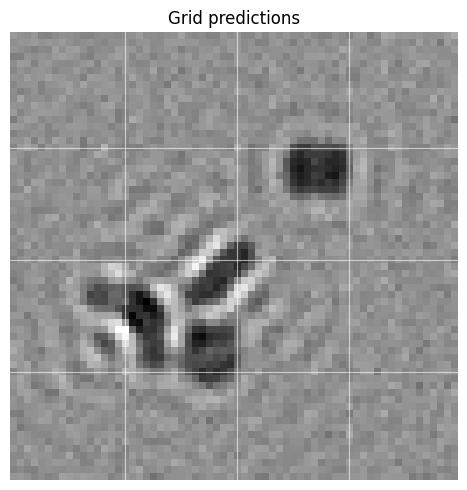

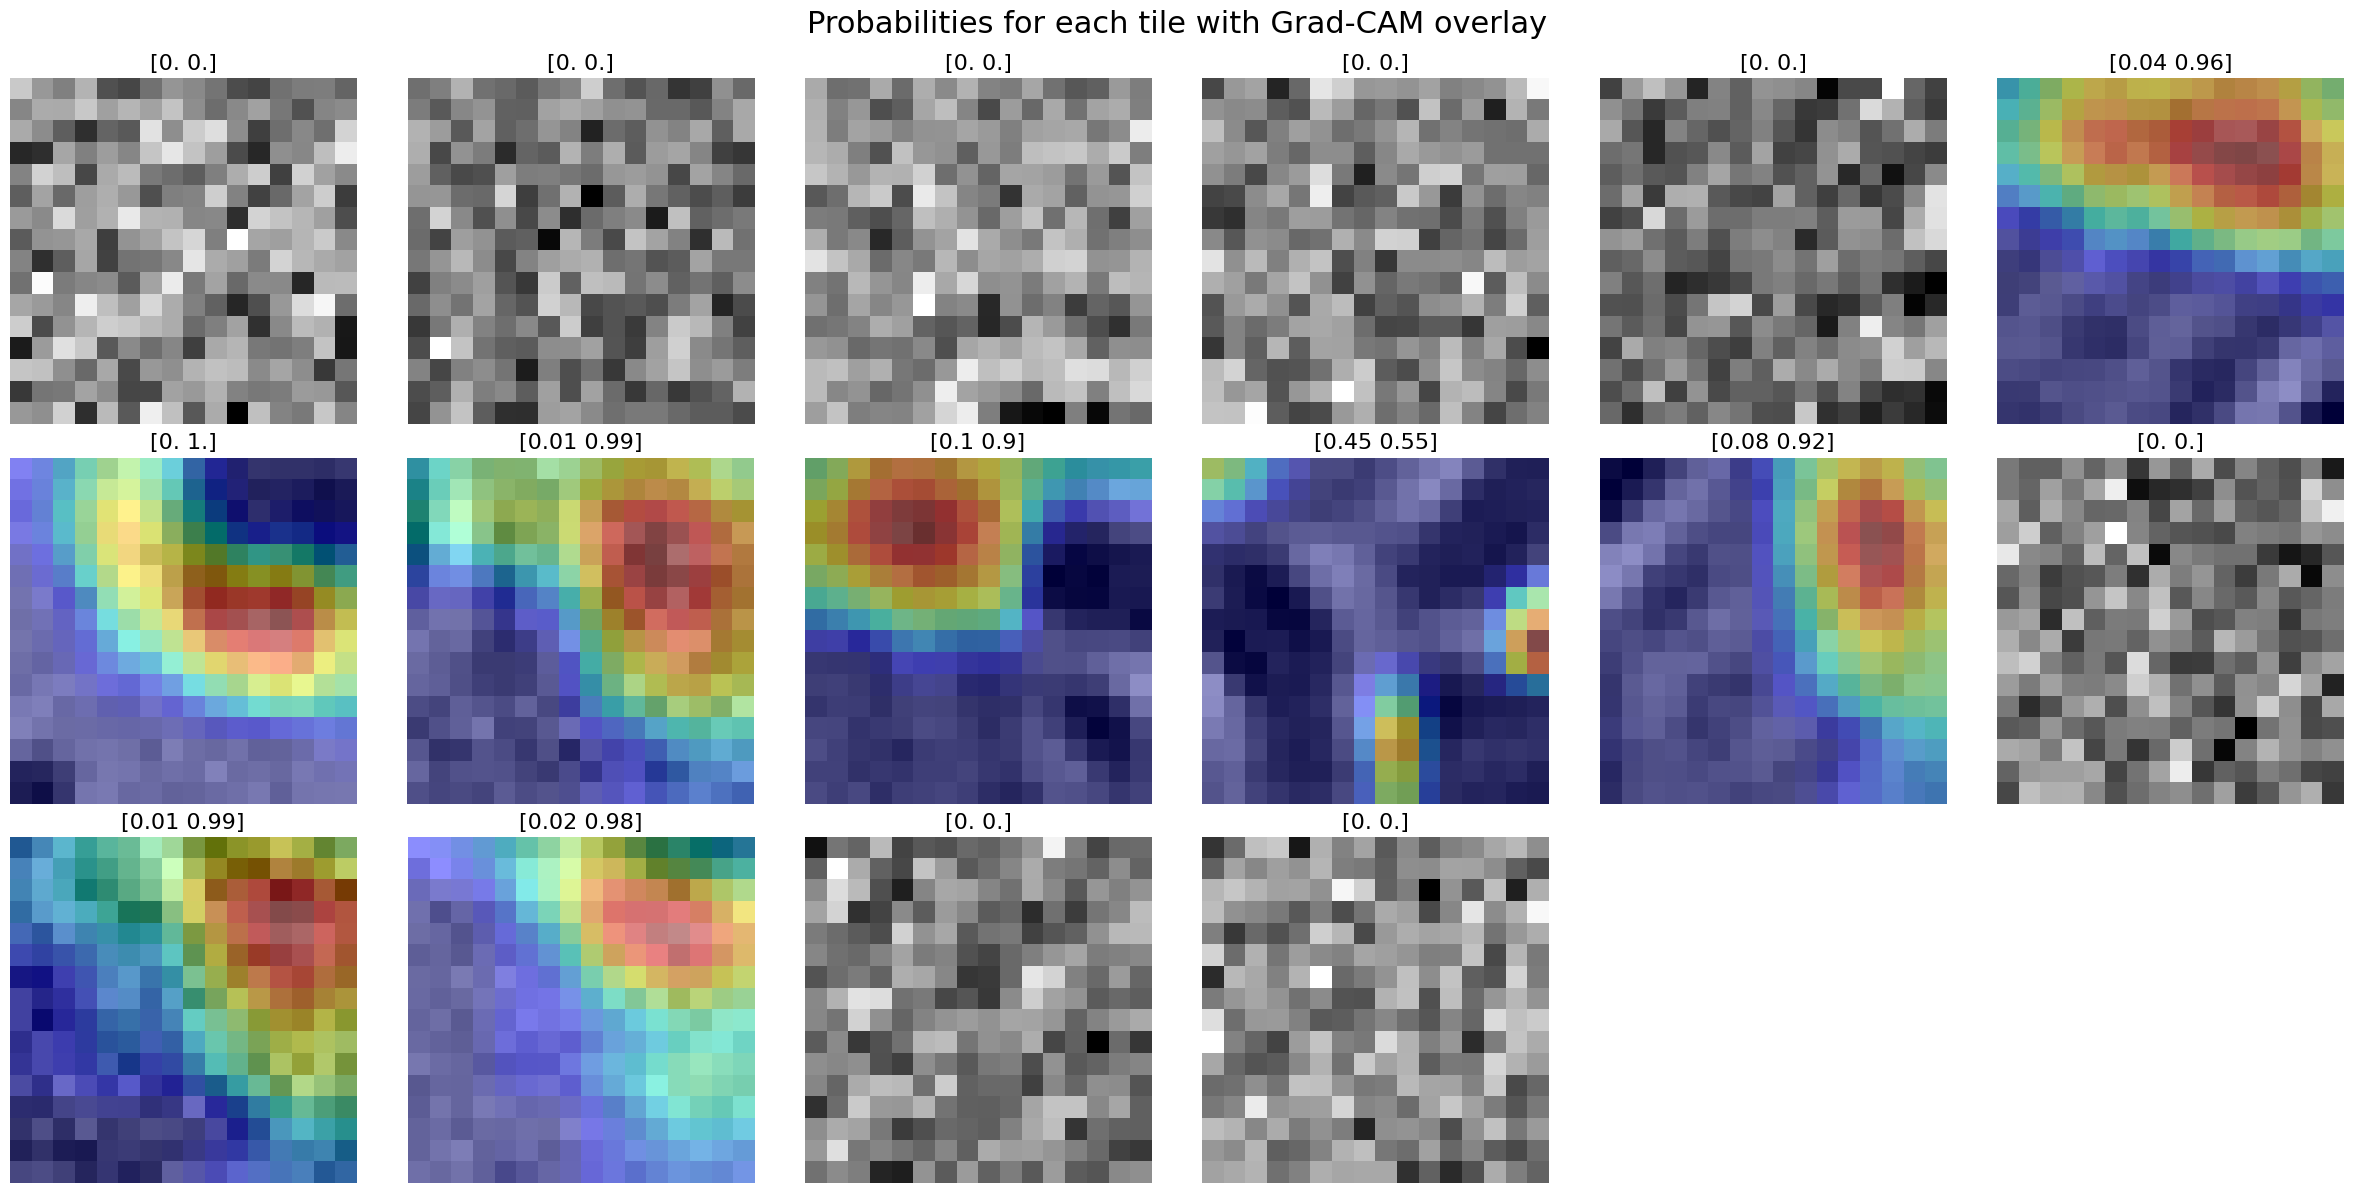

In [31]:
feat = make_image_feature(sphere(randint(0,5)) & ellipsoid(randint(0,5)))
feat.store_properties()
img_testing = feat.update().resolve()

out = apply_on_test_image(img_testing, grid=(4,4), device=device, encoder=enc_s, head=linear_dino, resize_to=32, none_threshold=0.75, presence_quantile=0.5)

preds = out["preds_with_none"]
names = out["classes_backgr"]
#print([names[i] for i in preds])

overlay_rgb, class_map, conf_map, per_class_score = cam_overlay(img = np.asarray(img_testing)[..., 0].astype(np.float32), coords = out["coords"], keep_mask = out["keep_mask"], tile_probs = out["probs"])

# **Creating bounding boxes surrounding peaks**
Used to detect peaks from the provided heatmap by identifying which pixels have a higher value than a specified threshold. Forms bounding boxes around these regions by using the base mask (the regions where the pixel intensities exceed out threshold). The peak_min_dist is then used to make sure that the peaks aren't treated as the same one and vice versa. The peaks are then expanded until values become lower than grow_thr (grow_frac regulates so that this value is alternating based on the different peaks). Then, these bounding boxes are returned.

In [32]:
def boxes_from_peaks(heat, thresh, peak_min_dist, grow_frac):
    """Finds the local peaks and returns a list of box surrounding the peaks."""
    base_mask = (heat >= thresh)
    size = int(max(2, peak_min_dist))
    hmax = maximum_filter(heat, size=size, mode='nearest')
    peaks = (heat ==hmax) & base_mask
    peak_lbl, n_peaks = ndi.label(peaks)
    boxes = []
    used = np.zeros_like(base_mask, dtype=bool)
    conn = generate_binary_structure(2,2)

    for i in range(1, n_peaks+1):
        py, px = np.argwhere(peak_lbl == i)[0]
        if used[py, px]:
            continue
        peak_val = heat[py, px]
        grow_thr = max(thresh, grow_frac*float(peak_val))
        region_mask = (heat>= grow_thr)
        seed = np.zeros_like(region_mask, dtype=bool)
        seed[py, px] = True
        allowed = region_mask & (~used)
        grown = binary_propagation(seed, mask=allowed, structure=conn)

        ys, xs = np.where(grown)
        y0, y1 = ys.min(), ys.max()+1
        x0, x1 = xs.min(), xs.max()+1
        boxes.append((y0,y1,x0,x1))
        used[grown] = True
    return boxes, base_mask

# **Creating and classifying image patches**
Here, we define the two functions that break down an image into smaller patches that we then can classify using the classify function. The approach is based on a "window" that is moved across the image using a step size (called stride here). Then, the classify-function can use the frozen encoder and head for classfication of these patches and returns the probabilities.

In [33]:
def create_patches(img, tile, stride):
    """Returns the patches and their coordinates."""
    H,W = img.shape
    for y0 in range(0, max(1, H-tile+1), stride):
        for x0 in range(0, max(1, W-tile+1), stride):
            y1 = min(y0 + tile, H)
            x1 = min(x0 + tile, W)
            patch = img[y0:y1, x0:x1]
            if patch.shape != (tile,tile):
                pad = ((0, tile-patch.shape[0]), (0, tile-patch.shape[1]))
                patch = np.pad(patch, pad, mode='edge')
            yield patch, (y0,y1,x0,x1)

def classify(patches, device, encoder, head, resize_to, global_min, global_max):
    """Classifies each patch and returns the probabilities"""
    xs = []
    for p in patches:
        p = p.astype(np.float32)
        p = (p-global_min)/(global_max-global_min + 1e-6)
        t = torch.from_numpy(p[None, None, ...])
        t = F.interpolate(t, size=(resize_to, resize_to), mode='bilinear')
        xs.append(t)
    x = torch.cat(xs, dim=0).to(device)
    with torch.no_grad():
        z = encoder(x)
        logits = head(z)
        probs = torch.softmax(logits, dim=1).cpu().numpy()
    return probs

# **Heatmap generation**

Here, we use the list of patches for each image and the corresponding predictions. The highest probability is then used to get a perception of the prediction confidence.

In [34]:
def create_heatmap(img, tile, stride, probs, boxes):
    """ Input: the original image, its tiles and their classification probs. Outputs a map showing where the model is confident in a particle being present."""
    H, W = img.shape
    heat = np.zeros((H, W))
    count = np.zeros((H, W))
    for p, (y0, y1, x0, x1) in zip(probs, boxes):
        yy1 = min(y1, H)
        xx1 = min(x1, W)
        score = float(np.max(p))
        heat[y0:yy1, x0:xx1] += score
        count[y0:yy1, x0:xx1] += 1.0
    heat = heat/count
    return heat

# **Classifying and creating a color overlay**

Classifies the box regions and creates a color overlay based on the predictions, red for spheres and blue for ellipsoids.

In [35]:
def classify_and_colorize(img, boxes, device, encoder, head, resize_to=32, pad_px=1):
    """Classifies the boxes and creates a colored overlay"""
    img = img.astype(np.float32)
    H, W = img.shape
    class_names=("Sphere","Ellipsoid")
    C = len(class_names)
    colors = np.array([[1,0,0], [0,0.5,1]])
    patches, regions = [],[]
    for (y0,y1,x0,x1) in boxes:
        yy0 = max(0, y0 - pad_px)
        yy1 = min(H, y1 + pad_px)
        xx0 = max(0, x0 - pad_px)
        xx1 = min(W, x1 + pad_px)
        if yy1 <= yy0 or xx1 <= xx0:
            continue
        crop = img[yy0:yy1, xx0:xx1]
        patches.append(crop)
        regions.append((yy0, yy1, xx0, xx1))

    probs = classify(patches, device, encoder, head, resize_to, global_min=float(img.min()), global_max=float(img.max()),)
    overlay = np.zeros((H, W, 3))
    weight = np.zeros((H, W))
    labels = []
    probs_list = []
    
    for p, (yy0, yy1, xx0, xx1) in zip(probs, regions):
        k = int(np.argmax(p))
        color = colors[k % len(colors)]
        overlay[yy0:yy1, xx0:xx1,:] +=color[None, None, :]
        weight [yy0:yy1, xx0:xx1]+=1

    overlay = overlay/(weight[..., None] + 1e-6)
    overlay = np.clip(overlay, 0.0, 1.0)
    return overlay, labels, probs_list

# **Applying all the functions above**
The detect_classify_colorize applies both scanning for particles, classfing, creating heatmaps and visualizing.

In [36]:
def detect_classify_colorize(img, device, encoder, head, tile, stride, thresh, resize_to):
    """Classifies and colors particels by sliding a window over the image,
    then classifies all the created "tiles", uses the scores to create a heatmap
    that in turned is used to pinpoint where particles are higly likely to be.
    Then it classifies the blob with an even tighter crop and adds a color overlay"""

    tiles, boxes = [],[]
    for patch, box in create_patches(img, tile, stride):
        tiles.append(patch)
        boxes.append(box)

    probs = classify(tiles, device, encoder, head, resize_to, global_min=float(img.min()), global_max=float(img.max()))

    for i, patch in enumerate(tiles):
        if patch.var() < 0.005: 
            probs[i] = 0
        
    heat = create_heatmap(img, tile, stride, probs, boxes)
    comp_boxes, mask = boxes_from_peaks(heat, thresh, peak_min_dist=3, grow_frac=0.8)
    overlay, labels, probs_list = classify_and_colorize(img, comp_boxes, device, encoder, head, resize_to)
    
    fig, axes = plt.subplots(1, 3, figsize=(14,5))
    axes[0].imshow(img, cmap='gray')
    axes[0].axis('off')
    im1 = axes[1].imshow(heat, cmap='magma')
    axes[1].axis('off')
    plt.colorbar(im1, ax=axes[1], fraction=0.046)
    axes[2].imshow(img, cmap='gray')
    axes[2].imshow(overlay, alpha=0.6)
    axes[2].axis('off')
    plt.tight_layout()
    plt.show()

    return {"heatmap": heat, "mask": mask, "boxes": comp_boxes, "overlay": overlay, "labels": labels, "probs_particle": probs_list}

# Creating a test image and applyting the functions for detection and colorization

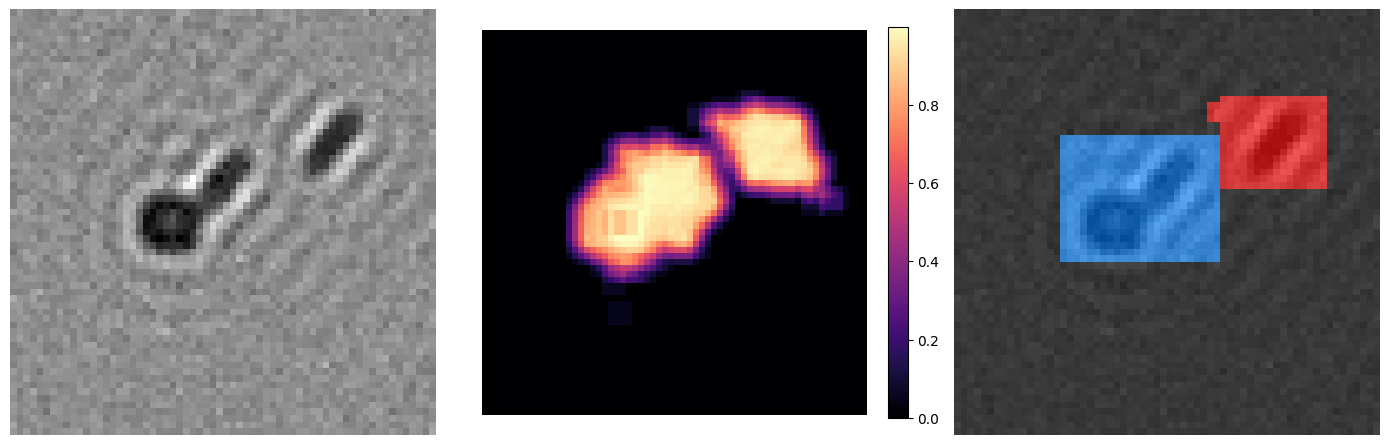

In [52]:
feat=make_image_feature(sphere(randint(1,2)) & ellipsoid(randint(1,2)))
feat.store_properties()
img = feat.update().resolve(skip_augmentations=False)
img = np.asarray(img)[..., 0].astype(np.float32)
out = detect_classify_colorize(img, device,encoder=enc_s, head=linear_dino, tile=4, stride=1, thresh=0.8, resize_to=32)

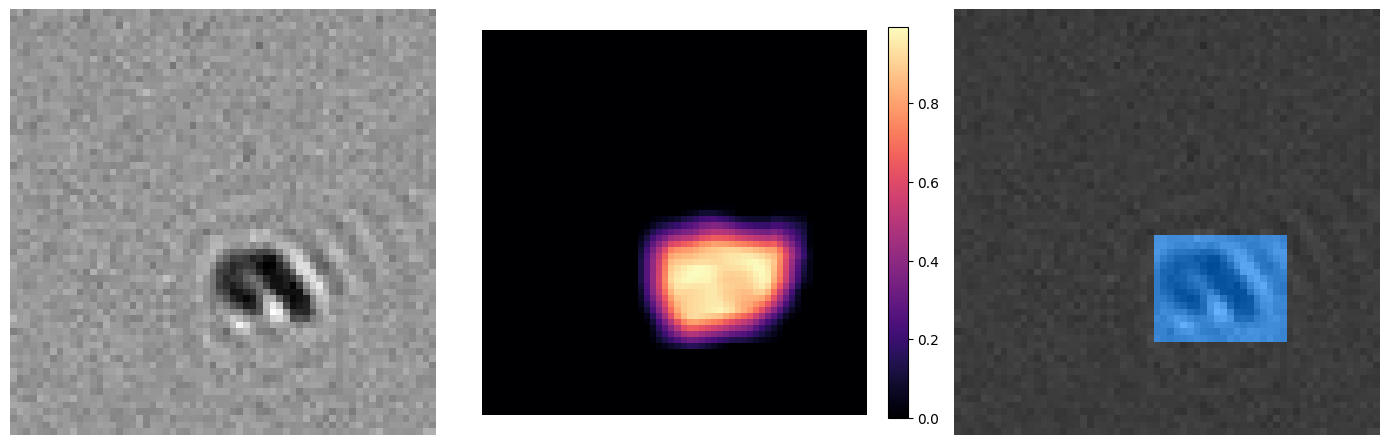

In [55]:
feat=make_image_feature(sphere(randint(1,3)) & ellipsoid(randint(1,3)))
feat.store_properties()
img = feat.update().resolve(skip_augmentations=False)
img = np.asarray(img)[..., 0].astype(np.float32)
out = detect_classify_colorize(img, device ,encoder=enc_s, head=linear_dino, tile=6, stride=1, thresh=0.6, resize_to=32)